In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import traceback
import random
import time

# 1.Deterministic environment

## Environment

In [2]:
class GridEnvironment(gym.Env):
    
    # Initializes the class
    def __init__(self):    
        self.observation_space = spaces.Discrete(16) #create observation-space
        self.action_space = spaces.Discrete(4) #create action-space
        self.time_step = 0 #create timestep-counter
        self.grid_size = 4 #create grid-size variable
        self.max_time_steps = 50 #set max possible transitions in an episode
        
    #takes 1 step forward in the env
    def step(self,action):
        
        next_state = self.get_next_state(action)  #get next-state for the current state,action pair
        reward = self.rewards[next_state] #get rewards for going the next-state
        self.rewards[next_state] = -1 #remove rewards and make it just an additional move 
        self.time_step += 1 #increase time-step
        done = True if self.time_step > self.max_time_steps else False #check if max time steps are exceeded
        info = {}
        return next_state, reward, done, info 
    
    #resets the env. 
    def reset(self):
        self.rewards = self.reset_rewards() #create/reset rewards for the env
        #self.state = 0 #set inital state to zero
        self.terminal_state = 15 #set terminal/goal state
        self.time_step = 1 #increase timestep
        pass
    
    #render current state
    def render(self):
        state = np.zeros((4,4))
        current_cell = self.state
        current_x,current_y = int(current_cell/4),int(current_cell%4)
        terminal_cell = self.terminal_state
        terminal_x,terminal_y = int(terminal_cell/4),int(terminal_cell%4)
        state[current_x,current_y] = 0.5
        state[terminal_x,terminal_y] = 1
        
        plot_env_current_state(state) #plot current state matrix of the env as an image
    
    #helper, resets rewards
    def reset_rewards(self):
        rewards = np.full((16),-1) 
        rewards[3] = 25
        rewards[10] = -10
        rewards[12] = -20
        rewards[13] = 10
        rewards[15] = 100
        return rewards
    
    #helper, gets next state given current state and action
    def get_next_state(self,action):
        x = int(self.state / self.grid_size)
        y = int(self.state % self.grid_size )

        if action == 0: #move left
            y -= 1
        elif action == 1: #move right
            y += 1
        elif action == 2: #move up
            x -= 1
        elif action == 3: #move down
            x += 1
        else:
            return -1
 
        x = np.clip(x,0,self.grid_size-1)
        y = np.clip(y,0,self.grid_size-1)
        next_state = (self.grid_size*x) + y
        
        return next_state
        

## Agent

In [3]:
class RandomAgent:
    #initialize the agent
    def __init__(self, env,epsilon,epsilon_decay_rate):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.terminal_state = env.terminal_state
        self.time_step = env.time_step 
        
        self.q_table = self.set_q_table() #Q-Table for the Agent(which is it's decision policy)
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate 
        
        self.action_type = -1 #tracker to track greedy and random actions
        
    #given current state,the agent takes a step to generate an action to perform
    def step(self, state):
        #generate action using epsilon greedy
        rand_num = np.random.random() 
        if self.epsilon > rand_num: # explore
            self.action_type = 0 #random
            return np.random.randint(self.action_space.n) 
        else: # exploit
            self.action_type = 1 #greedy
            return self.get_max_q_value_action(state) # gien a state, return action with maximum q-value
        return -1
        
    #resets the agent
    def reset(self):
        pass
    
    #initializes q-table(policy) for the agent to make decisions
    def set_q_table(self):
        q_table = np.full((self.observation_space.n , self.action_space.n),0) # states*actions
        for i in range(len(q_table[self.terminal_state])):
            q_table[self.terminal_state,i] = 0 #set all q-vals to 0
        return q_table
    
    #updates q-table after a transition
    def update_q_table(self,state,action,reward,next_state,learning_rate,discount_factor):
        #formula for Q-Learning
        FD = reward + discount_factor*(np.max(self.q_table[next_state]))
        TD = learning_rate*(FD - self.q_table[state,action])
        self.q_table[state,action] += TD
        
    #get max q value action given a particluar state
    def get_max_q_value_action(self,state):
        
        q_values = self.q_table[state] #all action q-values for the state
        best_actions = np.argwhere(q_values == np.amax(q_values)) #get the best ones with max-value
        
        #if multiple best actions, choose a random one
        if best_actions.shape[0] > 1:
            return np.random.choice(best_actions[0])
        
        return best_actions[0][0]

### plot-helpers

In [4]:
def plot_env_current_state(state,env_type,algo_type):    
    plt.figure(figsize=(3,3))
    plt.imshow(state)
    plt.title("Grid-State" + " for "+env_type+" using "+algo_type)
    plt.ylabel("y-axis")
    plt.xlabel("x-axis")
    plt.show()

def plot_eps_decay(epsilon_vals,env_type,algo_type):
    plt.figure(figsize=(10,6))
    plt.plot(epsilon_vals)
    plt.title('Epsilon-decay'+ " for "+env_type+" using"+algo_type)
    plt.ylabel('Epsilon')
    plt.xlabel('Epsiode No')
    plt.show()
    
def plot_cum_rewards(total_reward_per_ep,env_type,algo_type):
    plt.figure(figsize=(10,6))
    plt.plot(total_reward_per_ep)
    plt.title('Total Reward Per Episode'+ " for "+env_type+" using "+algo_type)
    plt.ylabel('Total Reward')
    plt.xlabel('Epsiode No')
    plt.show()
    
    
def plot_paths_travelled(total_path_travelled,env_type,algo_type):
    plt.figure(figsize=(10,6))
    plt.plot(total_path_travelled)
    plt.title('Total Path Travelled Per Episode' + " for "+env_type+" using "+algo_type)
    plt.ylabel('Steps made in Episode')
    plt.xlabel('Epsiode No')
    plt.show()
    
    
def plot_q_values_sum(q_values_sum,env_type,algo_type):
    plt.figure(figsize=(10,6))
    plt.plot(q_values_sum)
    plt.title('Q-Values SUM overtime'+ " for "+env_type+" using "+algo_type)
    plt.ylabel('SUM of Q-Value')
    plt.xlabel('Epsiode No')
    plt.show()
    
def plot_action_types_count(random_actions_per_ep,greedy_actions_per_ep,env_type,algo_type):
    plt.figure(figsize=(10,6))
    plt.plot(random_actions_per_ep, label = "random_actions_per_ep")
    plt.plot(greedy_actions_per_ep, label = "greedy_actions_per_ep")
    plt.title('Random vs Greedy actions took per EP'+ " for "+env_type+" using "+algo_type)
    plt.ylabel('Total Q-Value')
    plt.xlabel('Epsiode No')
    plt.legend(loc='best')
    plt.show()
    

## Main

In [18]:
env_type = "Deterministic Env"
algo_type = "Q-Learning"
def main(episodes=10,gamma=0.95,random_start_state=1,specific_start_state=0):
    
    #set parameters
    alpha = 0.15 #learning-rate
    #gamma = 0.9 #discount_factor
    
    epsilon = 1 #greedy/random factor
    epsilon_decay_rate = 0.001 #greedy/random factor decay rate

    #set tracking variables
    epsilon_vals = np.array([epsilon]) #do eps-decay
    total_path_travelled = np.array([]) #for no of tranisitions-made
    total_reward_per_ep = np.array([]) #for total rewards collected in an episode
    q_values_sum = np.array(-1) #to check the convergence of q-values
    random_actions_per_ep = np.array([]) #for no of random actions took per episode
    greedy_actions_per_ep = np.array([]) #for no of greedy actions took per episode
    total_actions_per_ep = np.array([]) #for no of overall actions took per episode(transitions made)
    state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)
    for i in range(state_rewards.shape[0]): #initialize the above variable
        state_rewards[i] = np.array([])
    
    #set environment and agent
    env = GridEnvironment()
    env.reset()
    agent = RandomAgent(env,epsilon,epsilon_decay_rate)
    agent.reset()
    
    #start training
    for ep in range(episodes):
        #now = time.time()
        #print("Episode No:",ep,"time taken till this ep:",np.round(now-program_starts,2),"s")
        
        env.reset() #reset env beore each episode
        agent.reset() #reset agent before each episode
        
        #check if we need a random start state or a specified start state for each epiode
        if random_start_state:
            #choose a random start state
            S = env.observation_space.sample()
            if S == env.terminal_state: # if inital state is final state, terminate the episode
                ep -= 1
                continue
        else:
            S = specific_start_state
        env.state = S #set env state to the chosen state
        
        #trackers for episodic data
        start_state = S #start state of the episode
        episode_path = np.array([]) #path of the episode
        episode_rewards = 0 #rewards collected in the episode
        greedy_count = 0 #greedy actions took in the episode
        random_count = 0 #random actions took in the episode
        total_count = 0 #all actions took in the episode(transitions)
                                         
        #till it's not a terminal state
        while S != env.terminal_state:  
            
            A = agent.step(S) #agent chooses an action
            NS , R, Done, Info = env.step(A) #env gives feedback for the action chosen through 
                                                                            #next available state,
                                                                            #reward recieved etc
            agent.update_q_table(S,A,R,NS,alpha,gamma) #agent updates it's Q-table(policy)
            
            episode_path = np.append(episode_path,S) #add to episode path
            episode_rewards += R #increase episode rewards
            
            #print(S,A,R,NS,episode_rewards)
            
            S = NS #change state to next state
            env.state = S #change environment's state
            
            #increase action counts accordingly
            if agent.action_type == 0: #random
                random_count += 1 
            if agent.action_type == 1: #greedy
                greedy_count += 1
            total_count += 1
            
            #if timesteps are maxed, terminate the episode
            if Done:
                break
                
            #env.render()
        
        #decay epsilon
        agent.epsilon = agent.epsilon*((1-agent.epsilon_decay_rate)**ep) #exponential decay
        agent.epsilon = max(agent.epsilon,0.01) #keep epsilon to a min value so that 
                                                #agent can explore even in latter stages
        
        #update all tracking-variables
        epsilon_vals = np.append(epsilon_vals,agent.epsilon) #
        total_reward_per_ep = np.append(total_reward_per_ep,episode_rewards)
        total_path_travelled = np.append(total_path_travelled,len(episode_path))
        q_values_sum = np.append(q_values_sum,agent.q_table.sum())
        random_actions_per_ep = np.append(random_actions_per_ep,random_count)
        greedy_actions_per_ep = np.append(greedy_actions_per_ep,greedy_count)
        total_actions_per_ep = np.append(total_actions_per_ep,total_count)
        state_rewards[start_state] = np.append(state_rewards[start_state],episode_rewards)
    
    #env.render() 
    print("Q-Table\n",agent.q_table)
    #print(get_all_states_max_reward_path(agent.q_table))
    plot_eps_decay(epsilon_vals,env_type,algo_type) #plot epsiolon values over time
    plot_cum_rewards(total_reward_per_ep,env_type,algo_type) #plot total rewards for each episode
    plot_paths_travelled(total_path_travelled,env_type,algo_type) #plot total transitions for each episode
    plot_q_values_sum(q_values_sum,env_type,algo_type) #plot avg q-values for each episode
    #plot actions type for each episode
    plot_action_types_count(random_actions_per_ep,greedy_actions_per_ep,env_type,algo_type) 
    #print(total_actions_per_ep)
    print("Starting-state,Total-Reward in an episode for all episodes ")
    for i in range(state_rewards.shape[0]): # for each state as an inital state
        print(i,list(state_rewards[i])) #print it's total episodic rewards
        

Q-Table
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  5  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0 -1]
 [ 0  0  5  0]
 [ 0  0  0 -5]
 [ 0  0  0  1]
 [ 0  1  0  9]
 [-1  0  0 27]
 [ 0  2  0  0]
 [-4 10  0  0]
 [ 0 54  0  0]
 [ 0  0  0  0]]


/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


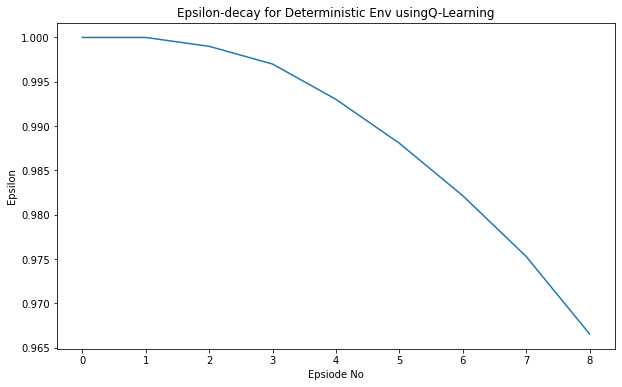

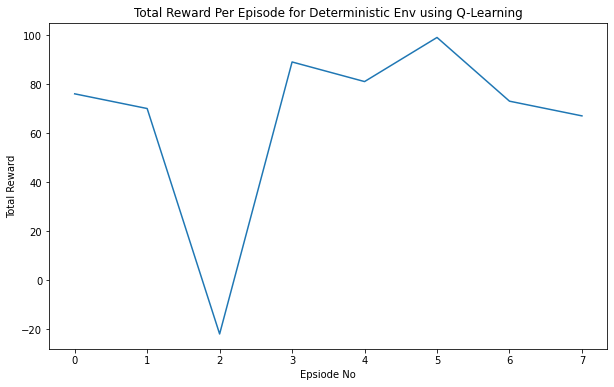

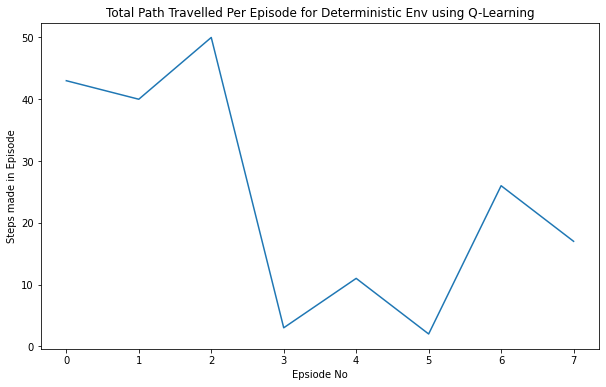

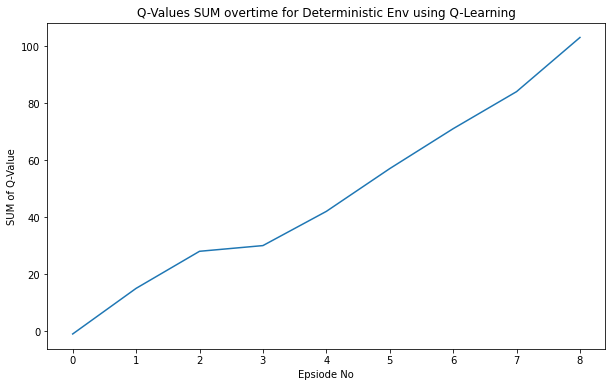

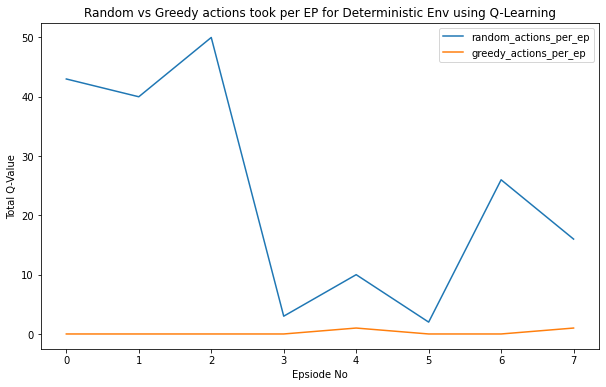

Starting-state,Total-Reward in an episode for all episodes 
0 []
1 []
2 []
3 []
4 [70.0]
5 [67.0]
6 [-22.0]
7 [81.0]
8 []
9 [89.0, 73.0]
10 []
11 []
12 []
13 [76.0, 99.0]
14 []
15 []


In [6]:
#run everything in default
main()

Q-Table
 [[ 0  0  0  9]
 [ 0  0  0 30]
 [ 0 57  1  6]
 [ 3 16 23 70]
 [ 3 41  0  0]
 [ 0 60  0 10]
 [ 9 71  1 19]
 [35 42 32 82]
 [ 1 23  0 -3]
 [ 1 11 13 68]
 [ 9 78  0 25]
 [39 59 48 94]
 [ 0 44  0  0]
 [-1 81 14 30]
 [ 6 94 17 22]
 [ 0  0  0  0]]


/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


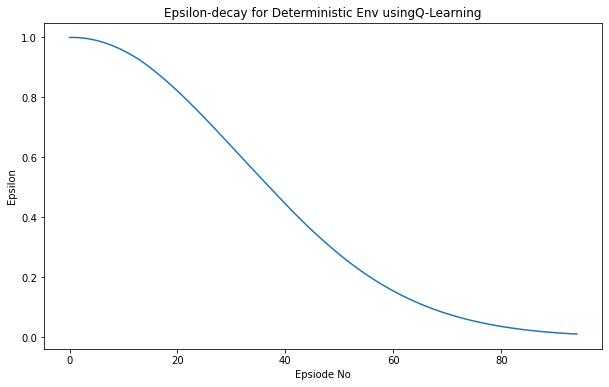

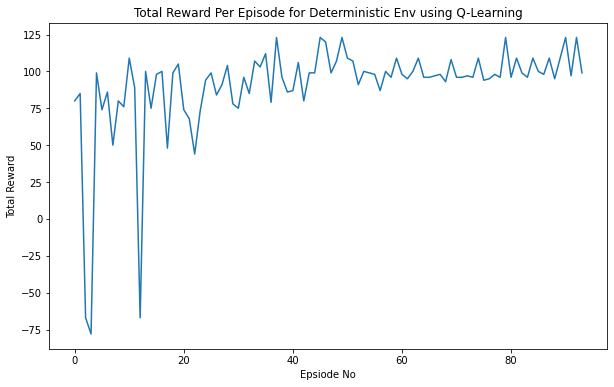

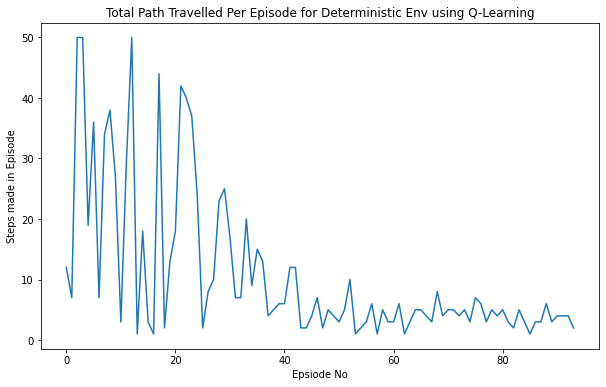

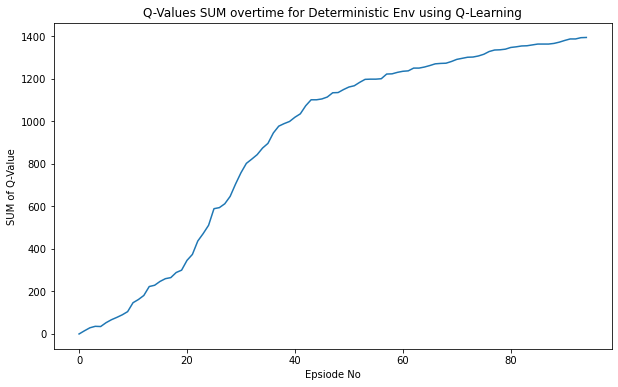

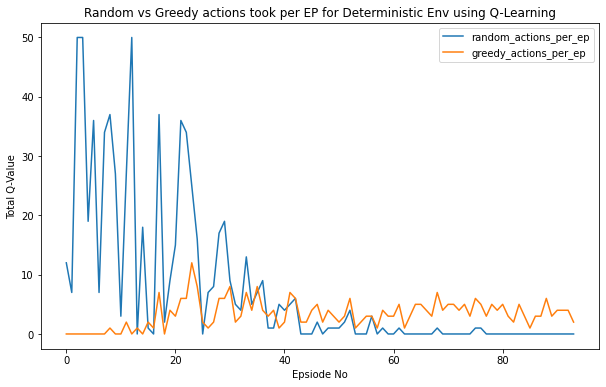

Starting-state,Total-Reward in an episode for all episodes 
0 [48.0, 74.0, 93.0, 94.0, 95.0]
1 [80.0, 89.0, 68.0, 73.0, 104.0, 96.0, 107.0, 96.0, 96.0, 96.0, 96.0]
2 [80.0, 105.0, 112.0, 123.0, 106.0, 123.0, 123.0, 123.0, 123.0]
3 [98.0, 96.0, 123.0, 98.0, 98.0, 98.0, 98.0]
4 [76.0, 96.0, 96.0, 96.0, 95.0, 96.0, 96.0]
5 [-67.0, 75.0, 84.0, 79.0, 120.0, 97.0, 97.0, 97.0]
6 [85.0, 91.0, 107.0, 98.0]
7 [94.0, 99.0, 85.0, 99.0, 99.0]
8 [-78.0, 78.0, 103.0, 80.0, 91.0, 95.0, 108.0]
9 [99.0, 109.0, -67.0, 44.0, 75.0, 107.0, 109.0, 109.0, 109.0, 109.0, 109.0, 109.0]
10 [99.0, 99.0, 99.0]
11 [100.0, 100.0, 100.0]
12 [87.0, 109.0, 109.0]
13 [74.0, 87.0, 99.0]
14 [86.0, 50.0, 99.0, 86.0, 100.0, 100.0, 100.0]
15 []


In [7]:
episodes = 100
main(episodes=episodes)

Q-Table
 [[ 0 64  0  0]
 [ 0 75  0  2]
 [ 0 86  3  5]
 [ 1  4  5 71]
 [ 0 60  0  1]
 [ 0 11  0 71]
 [ 1 12  1 62]
 [11 17 15 82]
 [ 1 71  0  2]
 [ 2 18 10 82]
 [ 3 29  1 82]
 [14 17 33 94]
 [ 6 82  0  2]
 [-1 82 14 44]
 [20 94 34 48]
 [ 0  0  0  0]]


/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


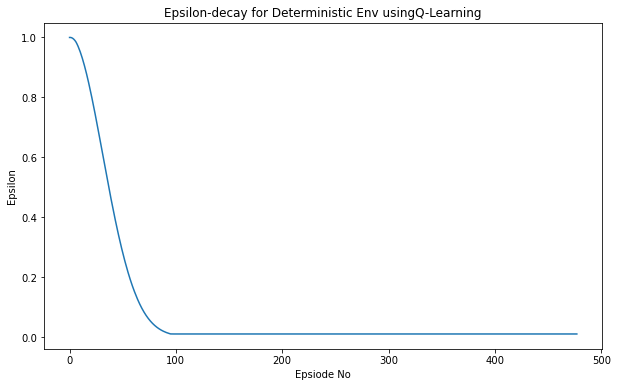

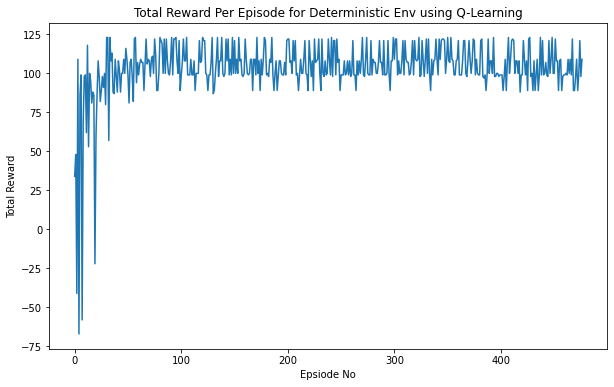

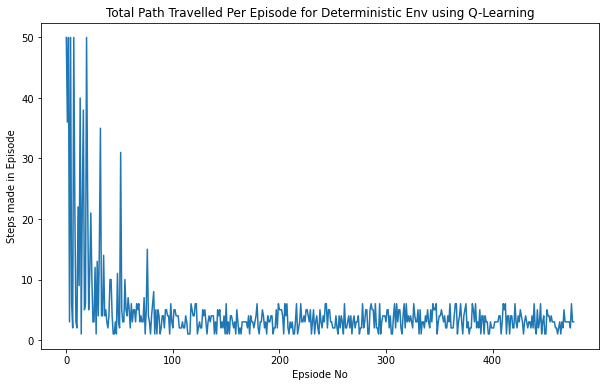

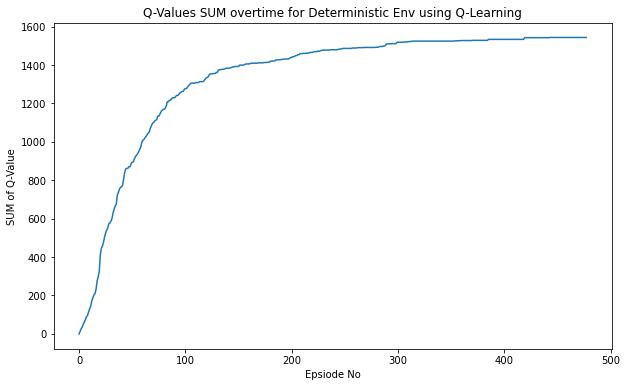

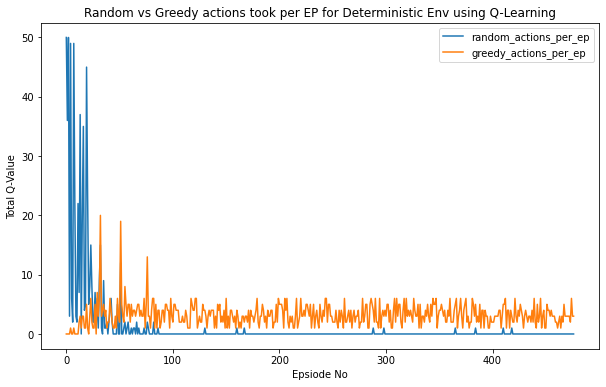

Starting-state,Total-Reward in an episode for all episodes 
0 [-41.0, 86.0, 81.0, -22.0, 98.0, 80.0, 57.0, 116.0, 81.0, 82.0, 112.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0]
1 [113.0, 108.0, 122.0, 122.0, 111.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0]
2 [-58.0, 60.0, 82.0, 123.0, 123.0, 123.0, 119.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0]
3 [118.0, 108.0, 123.0, 98.0, 94.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98

In [8]:
episodes = 500 
main(episodes=episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 8 64  0  0]
 [ 0 75  2  0]
 [11 86 13 10]
 [ 8 13 12 71]
 [ 0 50  0  9]
 [ 6 60 19  2]
 [ 8 71 10 20]
 [24 31 39 82]
 [ 9 71  0 -4]
 [ 9  7  0 82]
 [ 1 82  5 26]
 [35 53 54 94]
 [ 4 82  0  2]
 [10 82  4  5]
 [12 94 12 43]
 [ 0  0  0  0]]


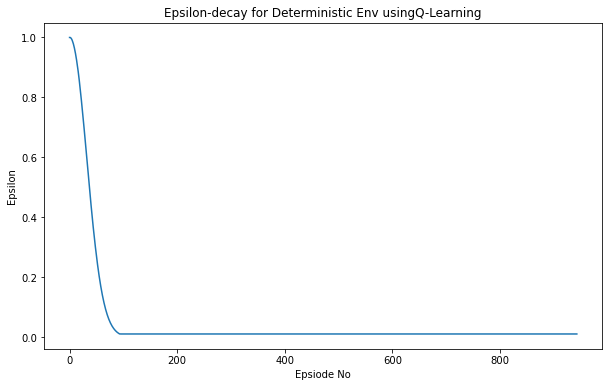

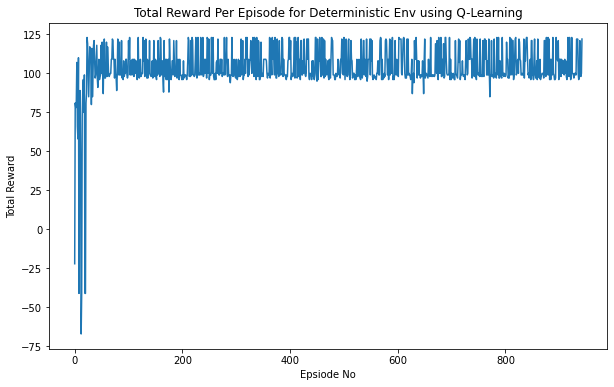

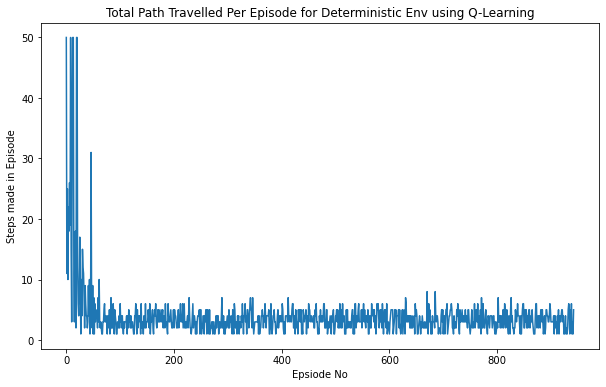

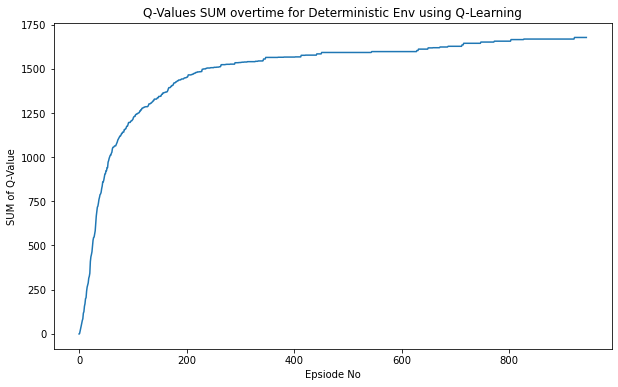

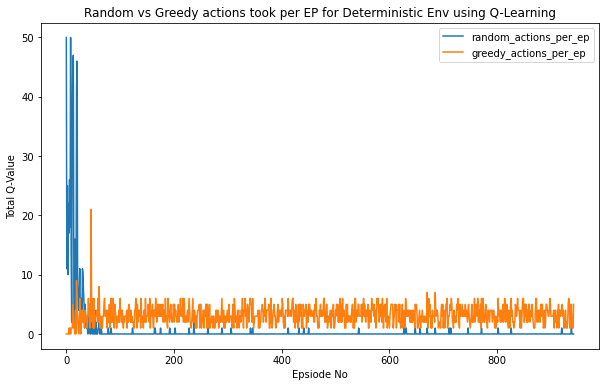

Starting-state,Total-Reward in an episode for all episodes 
0 [78.0, 96.0, -41.0, 112.0, 120.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 120.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 119.0, 121.0, 119.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0]
1 [118.0, 120.0, 122.0, 122.0, 120.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 120.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 120.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122.0]
2 [-41.0, -41.0, 116.0, 91.0, 122.0, 123.0, 123.0, 123.0, 123.0, 123

In [9]:
episodes = 1000
main(episodes=episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 0  0  0  0]
 [ 0  0  0 16]
 [ 0  8  0  2]
 [ 1  0  0  1]
 [ 0  0  0 15]
 [ 1  4  0 71]
 [ 3 17  0  7]
 [ 0 10  8 42]
 [ 3 61  0  3]
 [28 39 28 82]
 [ 8 18  1 81]
 [ 5 25  5 75]
 [ 2 54  3  0]
 [ 5 82 51 47]
 [42 94 43 68]
 [ 0  0  0  0]]


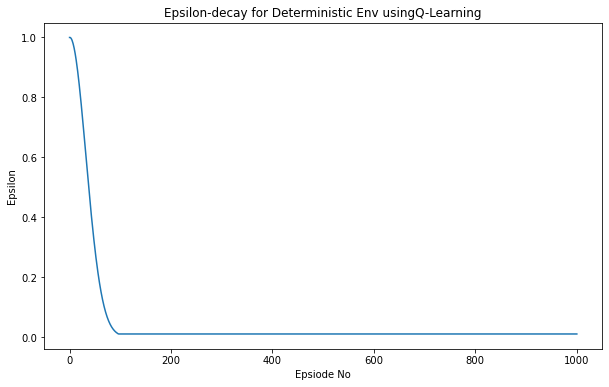

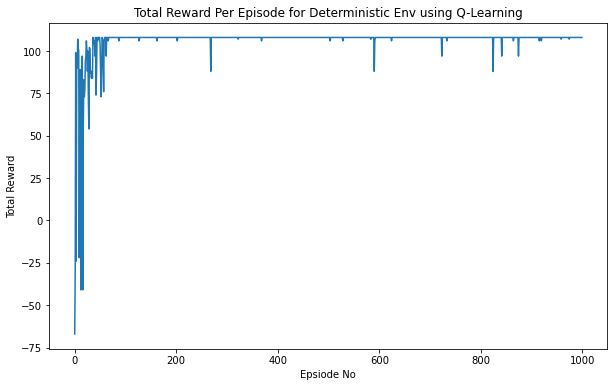

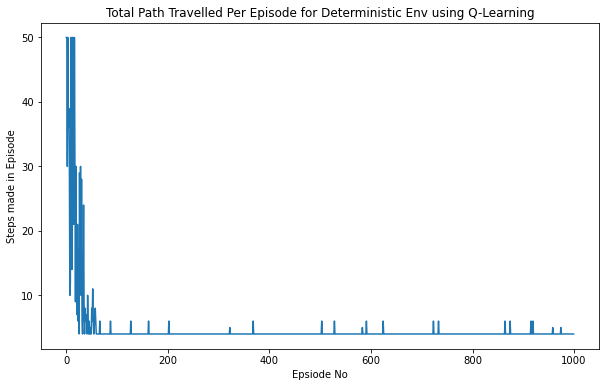

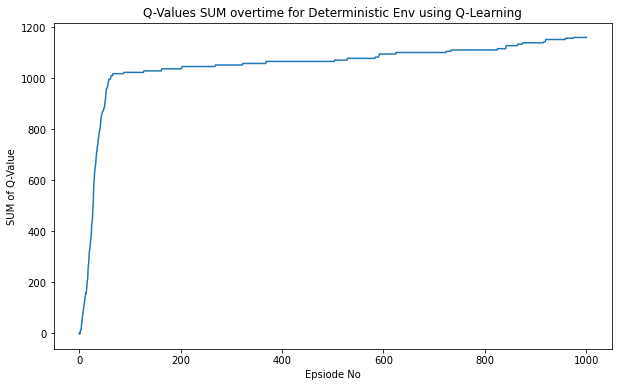

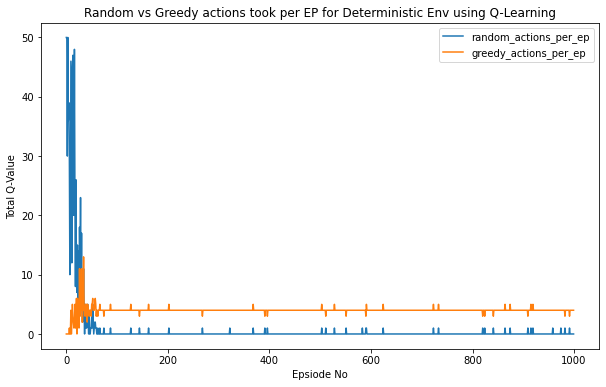

Starting-state,Total-Reward in an episode for all episodes 
0 []
1 []
2 []
3 []
4 []
5 [-67.0, -32.0, 99.0, -24.0, 93.0, 90.0, 107.0, 102.0, 100.0, -22.0, 66.0, 89.0, -41.0, -24.0, 86.0, 97.0, -41.0, 57.0, 83.0, 73.0, 77.0, 94.0, 97.0, 106.0, 101.0, 88.0, 100.0, 70.0, 54.0, 102.0, 101.0, 87.0, 88.0, 84.0, 88.0, 84.0, 108.0, 104.0, 106.0, 105.0, 97.0, 108.0, 74.0, 87.0, 108.0, 106.0, 108.0, 108.0, 107.0, 108.0, 104.0, 87.0, 73.0, 86.0, 108.0, 107.0, 96.0, 76.0, 106.0, 108.0, 108.0, 108.0, 97.0, 108.0, 108.0, 108.0, 106.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 106.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 106.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.0, 108.

In [10]:
episodes = 1000 
specific_start_state = 5
main(episodes=episodes,random_start_state=0,specific_start_state=specific_start_state)

### hyper param tuning for gamma(discount-factor, episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[44 64 37  8]
 [31 75 41 10]
 [53 86 61 43]
 [65 42 51 71]
 [ 0  0 34  0]
 [ 0 37  0  2]
 [ 0 71 31  9]
 [37 52 44 82]
 [ 0  6  0 -6]
 [ 0  0  0 29]
 [ 0 68  2 18]
 [28 71 62 94]
 [ 0  7  0  0]
 [-4 48  2  8]
 [ 4 81  7 18]
 [ 0  0  0  0]]


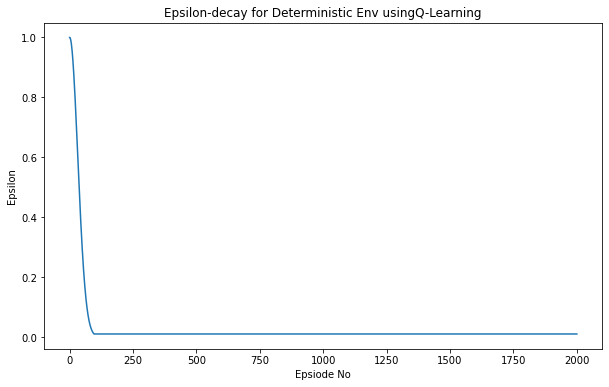

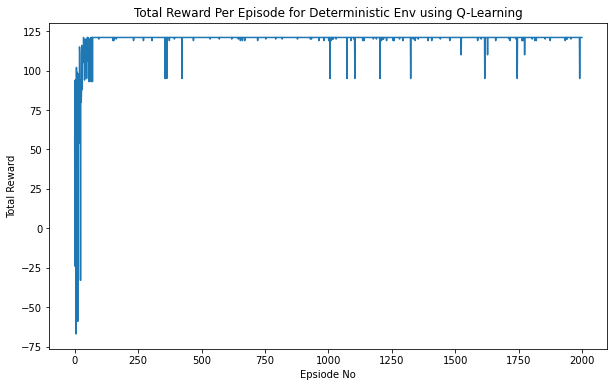

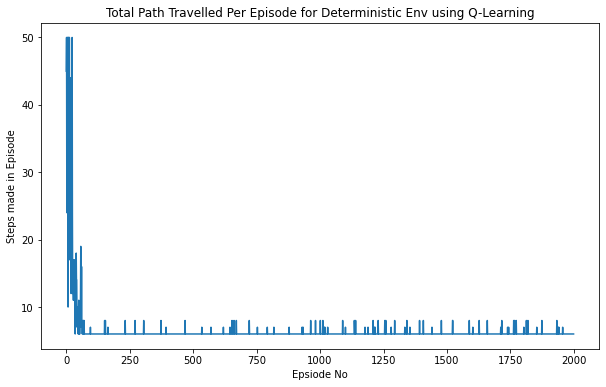

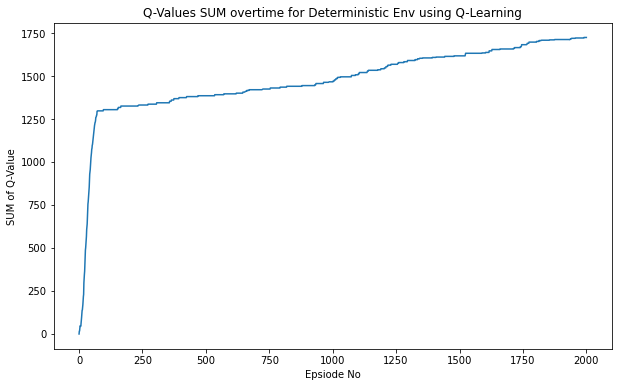

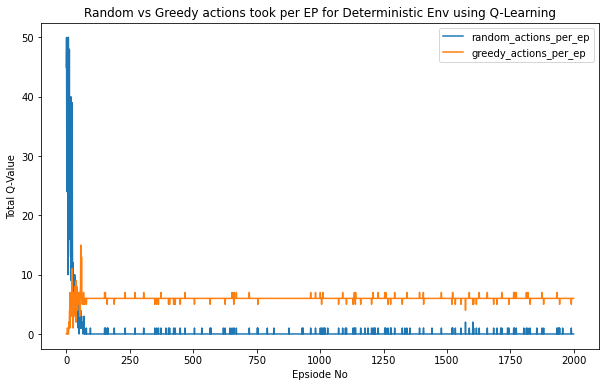

Starting-state,Total-Reward in an episode for all episodes 
0 [58.0, -24.0, 94.0, 43.0, -24.0, -67.0, -33.0, 102.0, -22.0, 99.0, -52.0, 96.0, -59.0, 58.0, 67.0, 55.0, 98.0, 75.0, 59.0, 115.0, 111.0, 54.0, 72.0, -33.0, 94.0, 80.0, 81.0, 88.0, 116.0, 101.0, 88.0, 115.0, 105.0, 112.0, 110.0, 121.0, 115.0, 119.0, 119.0, 94.0, 113.0, 113.0, 118.0, 120.0, 117.0, 117.0, 118.0, 95.0, 118.0, 116.0, 121.0, 117.0, 121.0, 106.0, 118.0, 119.0, 115.0, 93.0, 120.0, 110.0, 111.0, 119.0, 120.0, 121.0, 120.0, 93.0, 121.0, 121.0, 119.0, 121.0, 93.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 120.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 1

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[26 37 25 18]
 [12 39 33 47]
 [ 1 62  6  5]
 [10 14 12 59]
 [ 0 47  0  1]
 [25 39 32 57]
 [ 3  9  6 66]
 [ 4 29 16 79]
 [ 0 49  0  1]
 [26 67 42 59]
 [49 64 34 82]
 [36 15 16 94]
 [ 2 29  0  8]
 [ 3 82 15 17]
 [72 94 63 76]
 [ 0  0  0  0]]


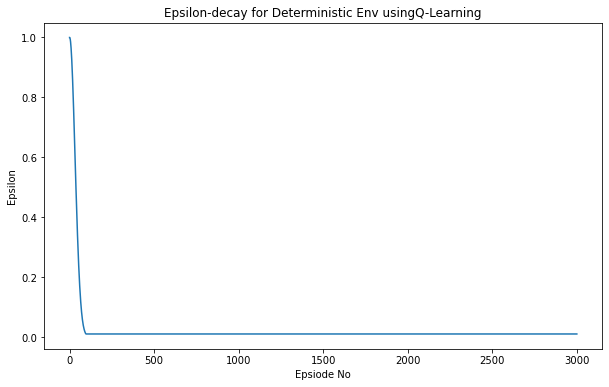

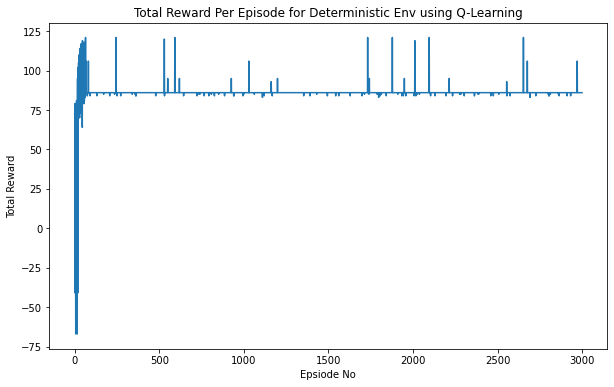

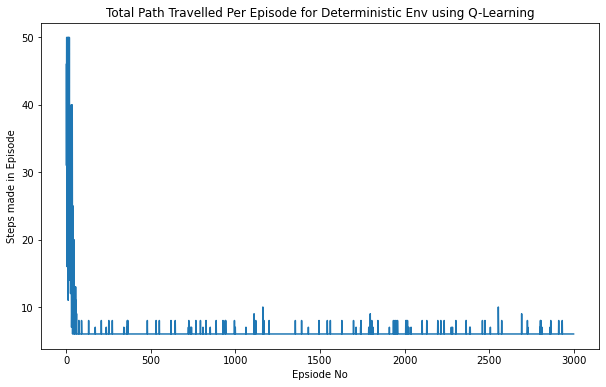

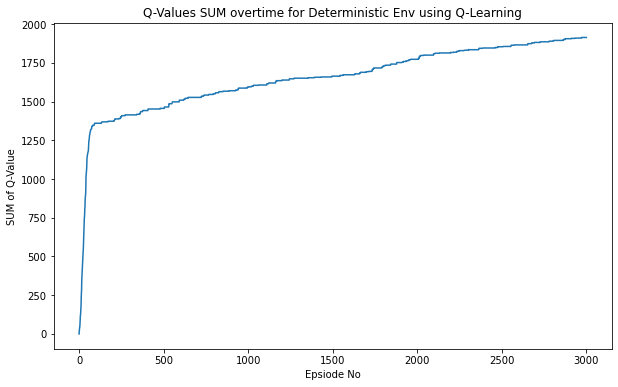

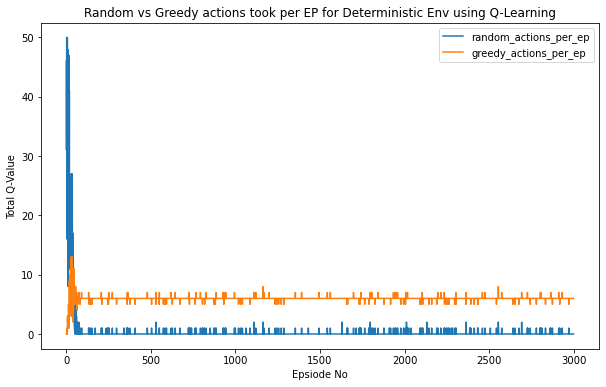

Starting-state,Total-Reward in an episode for all episodes 
0 [72.0, 79.0, -41.0, -13.0, 76.0, 59.0, -67.0, -58.0, -24.0, -41.0, 70.0, 81.0, -41.0, 73.0, -67.0, -67.0, 72.0, 95.0, -41.0, 102.0, 78.0, 74.0, 73.0, 105.0, 88.0, 80.0, 110.0, 102.0, 93.0, 70.0, 114.0, 85.0, 94.0, 73.0, 83.0, 78.0, 74.0, 86.0, 117.0, 89.0, 102.0, 85.0, 106.0, 84.0, 84.0, 64.0, 119.0, 84.0, 86.0, 84.0, 86.0, 86.0, 86.0, 85.0, 85.0, 79.0, 118.0, 81.0, 86.0, 85.0, 94.0, 83.0, 86.0, 86.0, 121.0, 86.0, 86.0, 106.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 84.0, 84.0, 86.0, 86.0, 86.0, 86.0, 86.0, 106.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 84.0, 85.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 84.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86.0, 86

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[50 64 47 27]
 [51 75 60 39]
 [60 86 61 60]
 [62 58 55 71]
 [ 0 42  0  0]
 [ 0  5  8 52]
 [ 3 71 10 23]
 [49 71 60 82]
 [ 0 12  0 -8]
 [ 0 62  3 12]
 [15 82  6 33]
 [61 82 65 94]
 [ 0  4  0  0]
 [-8 32  0  1]
 [ 2 75 25 32]
 [ 0  0  0  0]]


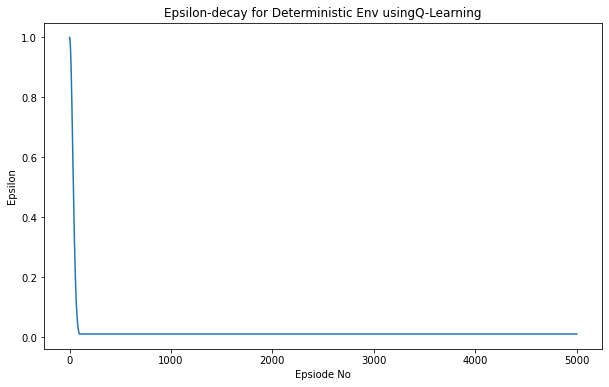

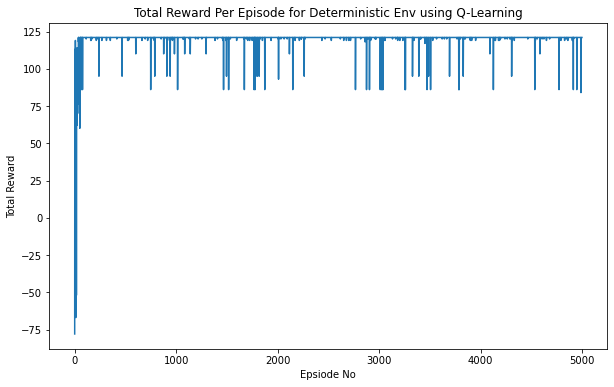

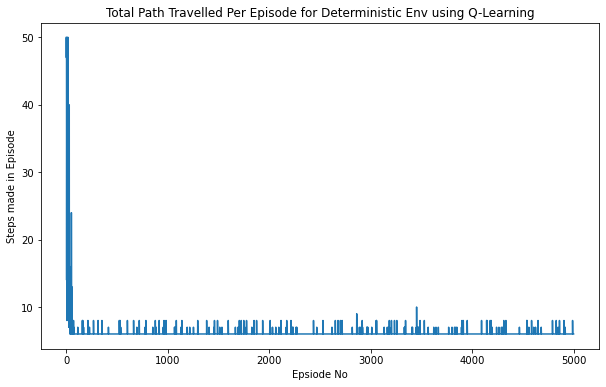

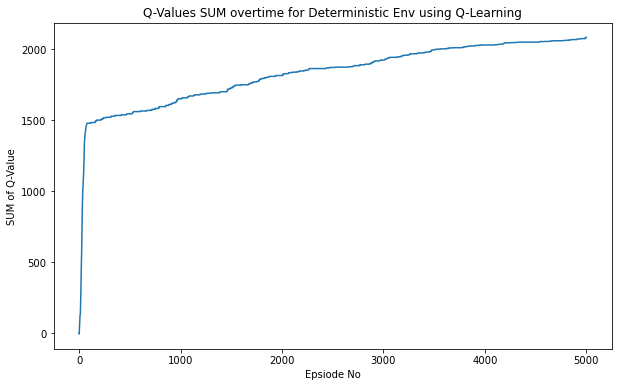

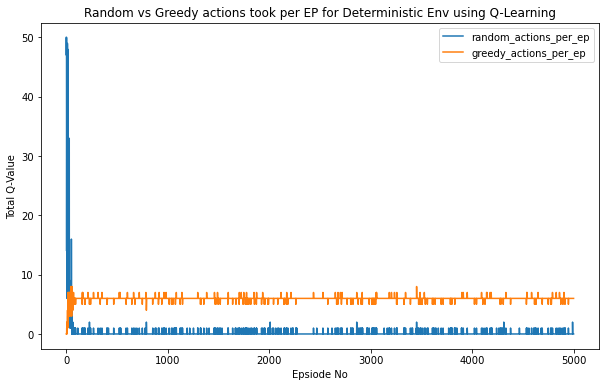

Starting-state,Total-Reward in an episode for all episodes 
0 [-78.0, 71.0, -22.0, 113.0, 45.0, 58.0, 54.0, 119.0, 62.0, 70.0, -39.0, -67.0, -48.0, 114.0, 56.0, -52.0, 86.0, -52.0, 104.0, 91.0, 79.0, 62.0, 97.0, 93.0, 94.0, 76.0, 100.0, 77.0, 98.0, 70.0, 109.0, 82.0, 114.0, 94.0, 82.0, 113.0, 95.0, 121.0, 118.0, 121.0, 94.0, 120.0, 118.0, 121.0, 83.0, 116.0, 115.0, 76.0, 118.0, 117.0, 60.0, 117.0, 84.0, 84.0, 121.0, 114.0, 121.0, 86.0, 121.0, 120.0, 120.0, 121.0, 121.0, 121.0, 86.0, 86.0, 121.0, 121.0, 121.0, 121.0, 120.0, 119.0, 121.0, 121.0, 120.0, 121.0, 121.0, 86.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 120.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121

In [19]:
episodes_list = [2000,3000,5000]
for episodes in episodes_list: 
    main(episodes=episodes,random_start_state=0,specific_start_state=0)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0 17  0  0]
 [ 0  0  0 10]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  8  0  0]
 [ 0  5  7 37]
 [ 0  5  0 -9]
 [ 0  1  0 24]
 [ 0 35  0 11]
 [ 3 22  2 94]
 [ 0 17  0  0]
 [-5 40  2  5]
 [ 2 94  0 10]
 [ 0  0  0  0]]


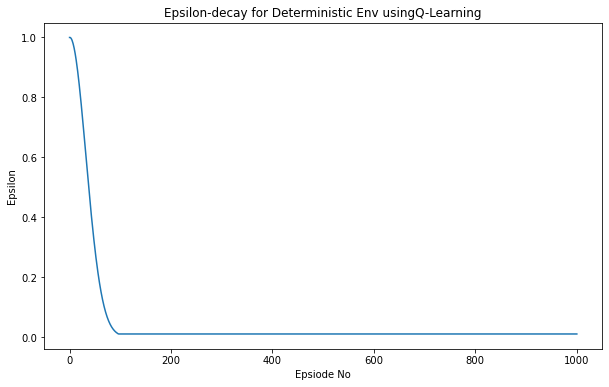

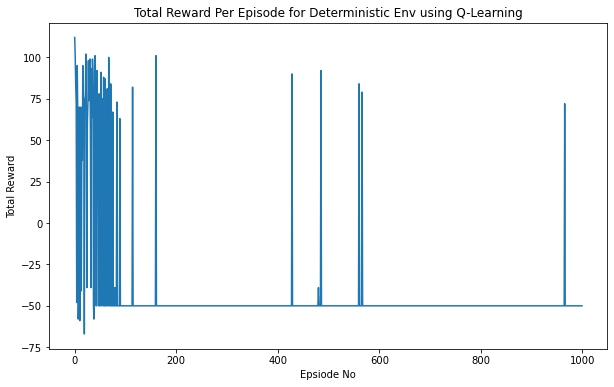

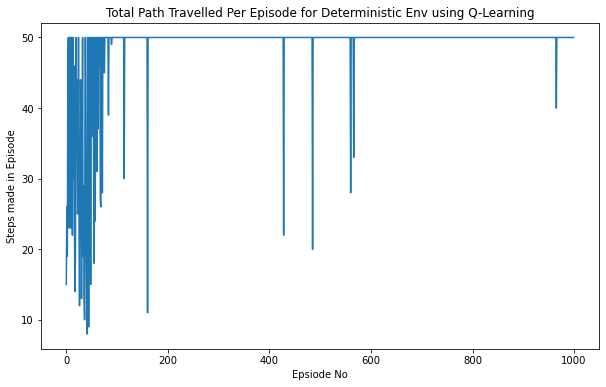

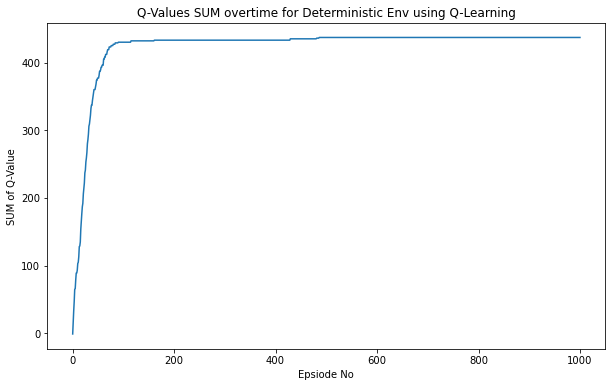

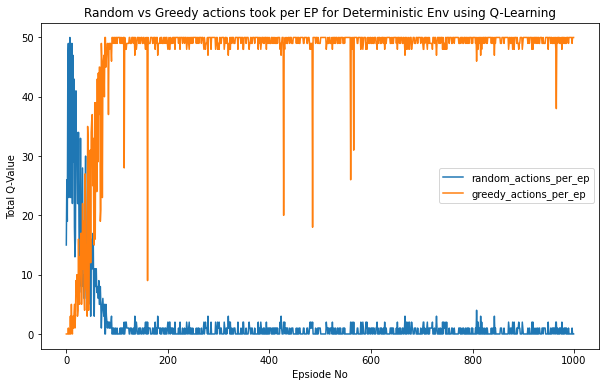

Starting-state,Total-Reward in an episode for all episodes 
0 [112.0, 101.0, 84.0, 72.0, -48.0, 95.0, 68.0, -58.0, -41.0, 70.0, -59.0, -22.0, 70.0, -41.0, 43.0, 38.0, 95.0, 78.0, 73.0, -67.0, 75.0, 74.0, 102.0, 66.0, -39.0, 60.0, 72.0, 98.0, 74.0, 74.0, 99.0, 56.0, -39.0, 93.0, 64.0, 99.0, 91.0, -50.0, -58.0, 81.0, 101.0, 84.0, -50.0, -50.0, 92.0, 57.0, 69.0, -50.0, 78.0, -50.0, -50.0, 64.0, 91.0, -50.0, 68.0, 75.0, -50.0, 88.0, -50.0, -50.0, 87.0, -50.0, 56.0, -50.0, 81.0, -50.0, -50.0, 100.0, 67.0, -50.0, -50.0, 84.0, -50.0, -50.0, -50.0, 67.0, -50.0, -50.0, -50.0, -39.0, -50.0, -50.0, -50.0, 73.0, -50.0, -50.0, -50.0, -50.0, -50.0, 63.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 82.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -5

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 3 15  2  0]
 [ 4 30 11  0]
 [ 9 49 24  8]
 [17 13 12 40]
 [ 0  0  0  0]
 [ 0  0  3 11]
 [ 0 36 14  6]
 [12 35 21 63]
 [ 0  9  0 -7]
 [ 0  9  0 38]
 [ 4 58  2 20]
 [20 52 28 94]
 [ 1 19  0  0]
 [ 0 57  2  7]
 [16 90 12 21]
 [ 0  0  0  0]]


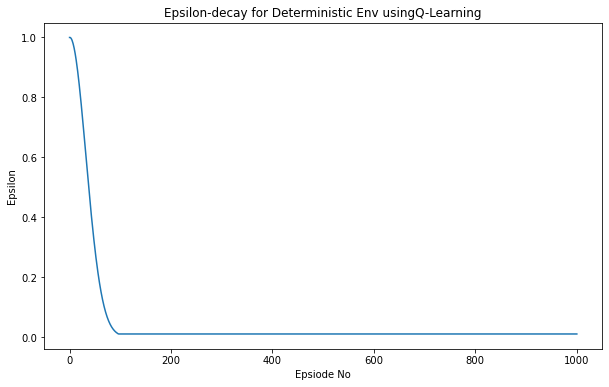

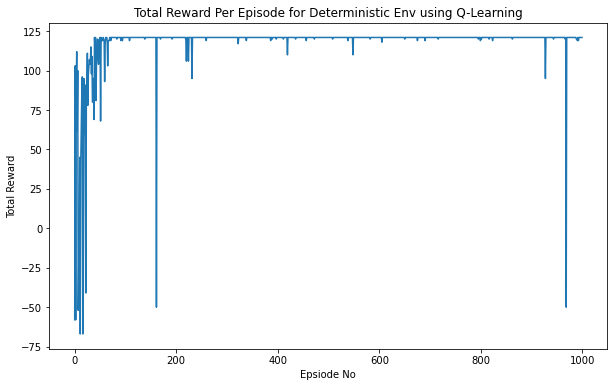

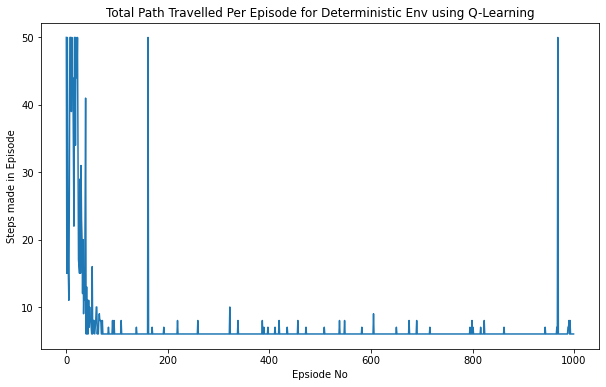

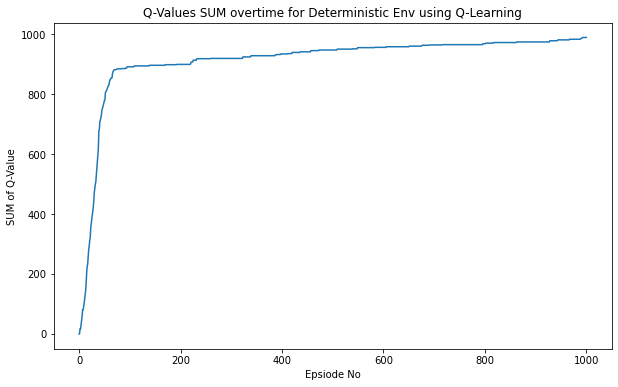

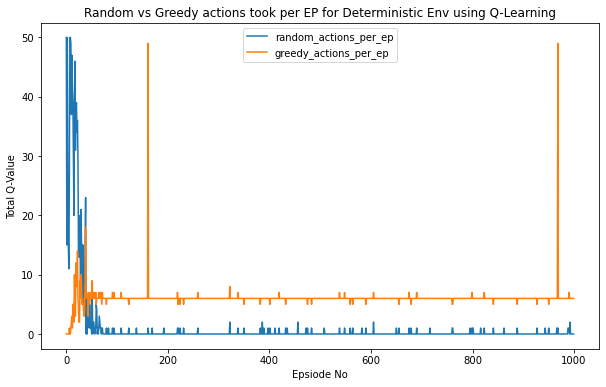

Starting-state,Total-Reward in an episode for all episodes 
0 [-58.0, 103.0, -58.0, 91.0, 112.0, 62.0, 100.0, -52.0, -22.0, -33.0, 45.0, -67.0, 42.0, 66.0, 86.0, 96.0, -67.0, -41.0, 95.0, 60.0, 91.0, 55.0, -41.0, 83.0, 95.0, 111.0, 78.0, 98.0, 103.0, 107.0, 104.0, 107.0, 115.0, 98.0, 109.0, 80.0, 81.0, 95.0, 69.0, 121.0, 114.0, 121.0, 81.0, 106.0, 116.0, 120.0, 108.0, 104.0, 119.0, 120.0, 121.0, 68.0, 121.0, 119.0, 119.0, 119.0, 121.0, 120.0, 119.0, 93.0, 117.0, 121.0, 120.0, 121.0, 119.0, 103.0, 119.0, 119.0, 119.0, 121.0, 121.0, 119.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 120.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 119.0, 121.0, 121.0, 119.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 119.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 1

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/559976645.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[18 47 12  3]
 [22 60 21  4]
 [24 75 32  9]
 [17 25 13 62]
 [ 0  0  2 12]
 [ 0  0  0 21]
 [ 0 44  0  9]
 [ 8 29 32 77]
 [ 1  8  0 26]
 [ 1 17  1 50]
 [ 7 66  0 30]
 [27 66 14 94]
 [ 5 66  0 16]
 [13 77 14 12]
 [18 94 10 56]
 [ 0  0  0  0]]


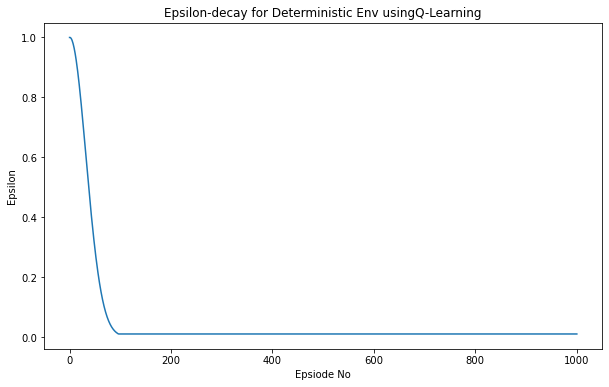

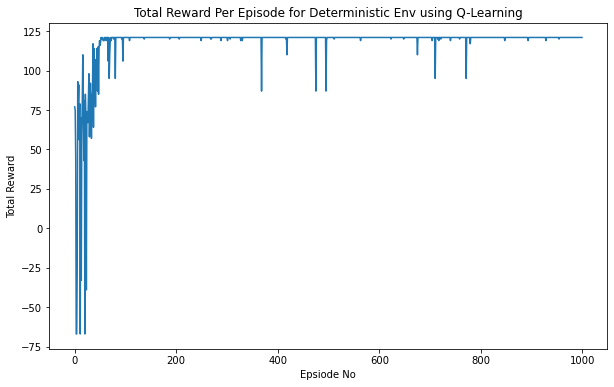

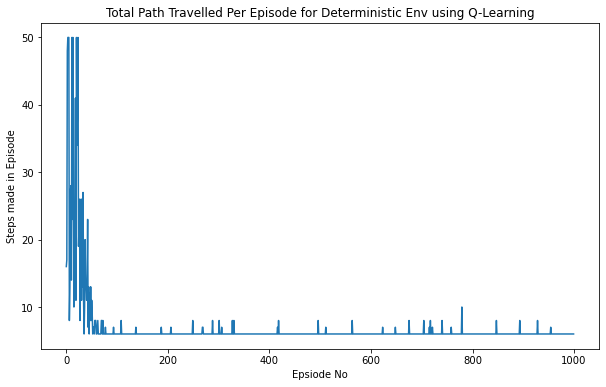

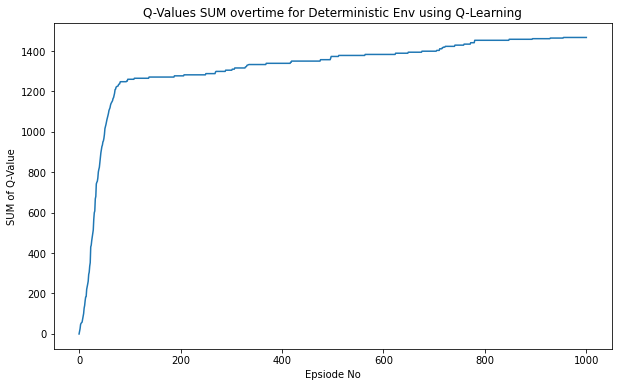

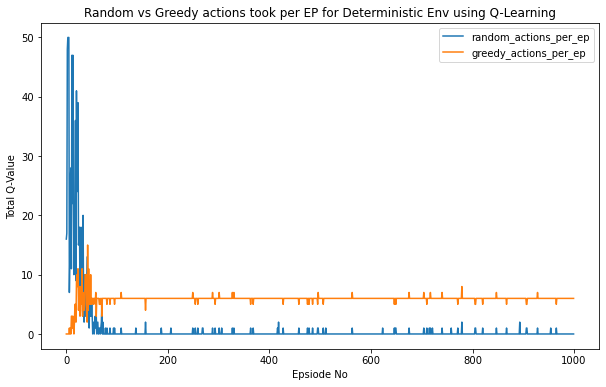

Starting-state,Total-Reward in an episode for all episodes 
0 [77.0, 75.0, 45.0, -67.0, -67.0, -24.0, 93.0, 79.0, 91.0, 56.0, 79.0, -67.0, 70.0, -33.0, 60.0, 82.0, 110.0, 77.0, 43.0, 81.0, -67.0, 85.0, 70.0, -39.0, 74.0, 71.0, 67.0, 84.0, 98.0, 58.0, 82.0, 92.0, 80.0, 57.0, 82.0, 87.0, 117.0, 64.0, 114.0, 80.0, 107.0, 77.0, 104.0, 105.0, 114.0, 87.0, 115.0, 85.0, 114.0, 119.0, 116.0, 118.0, 121.0, 120.0, 120.0, 121.0, 119.0, 119.0, 119.0, 121.0, 121.0, 120.0, 119.0, 121.0, 121.0, 121.0, 106.0, 121.0, 95.0, 110.0, 119.0, 121.0, 119.0, 121.0, 121.0, 121.0, 121.0, 120.0, 121.0, 121.0, 95.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 120.0, 121.0, 106.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 119.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 121.0, 120.0, 121.0,

In [22]:
gamma_list = [0.5,0.75,0.9]
for gamma in gamma_list: 
    main(episodes=1000,gamma=gamma,random_start_state=0,specific_start_state=0)

## 2.stochastic env

In [11]:
class GridEnvironment_stochastic(GridEnvironment):
    
    def get_next_state(self,action):
        x = int(self.state / 4)
        y = int(self.state % 4 )

        if action == 0: #left            
            choice = random.choices([0,1],k=1, weights=(0.2,0.8))
            y -= choice[0]
        elif action == 1: #right
            choice = random.choices([0,1],k=1, weights=(0.1,0.9))   
            y += choice[0]
        elif action == 2: #up
            choice = random.choices([-1,1],k=1, weights=(0.3,0.7))  
            x -= choice[0]
        elif action == 3: #down
            choice = random.choices([-1,0,1],k=1, weights=(0.25,0.25,0.5))   
            x += choice[0]
        else:
            return -1
 
        x = np.clip(x,0,3)
        y = np.clip(y,0,3)
        next_state = 4*x + y
        
        return next_state

In [12]:
env_type = "Stochastic Env"
algo_type = "Q-Learning"
def main(episodes=10,gamma=0.95,random_start_state=1,specific_start_state=0):
    
    #set parameters
    alpha = 0.15 #learning-rate
    #gamma = 0.9 #discount_factor
    
    epsilon = 1 #greedy/random factor
    epsilon_decay_rate = 0.001 #greedy/random factor decay rate

    #set tracking variables
    epsilon_vals = np.array([epsilon]) #do eps-decay
    total_path_travelled = np.array([]) #for no of tranisitions-made
    total_reward_per_ep = np.array([]) #for total rewards collected in an episode
    q_values_sum = np.array(-1) #to check the convergence of q-values
    random_actions_per_ep = np.array([]) #for no of random actions took per episode
    greedy_actions_per_ep = np.array([]) #for no of greedy actions took per episode
    total_actions_per_ep = np.array([]) #for no of overall actions took per episode(transitions made)
    state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)
    for i in range(state_rewards.shape[0]): #initialize the above variable
        state_rewards[i] = np.array([])
    
    #set environment and agent
    env = GridEnvironment_stochastic()
    env.reset()
    agent = RandomAgent(env,epsilon,epsilon_decay_rate)
    agent.reset()
    
    #start training
    for ep in range(episodes):
        #now = time.time()
        #print("Episode No:",ep,"time taken till this ep:",np.round(now-program_starts,2),"s")
        
        env.reset() #reset env beore each episode
        agent.reset() #reset agent before each episode
        
        #check if we need a random start state or a specified start state for each epiode
        if random_start_state:
            #choose a random start state
            S = env.observation_space.sample()
            if S == env.terminal_state: # if inital state is final state, terminate the episode
                ep -= 1
                continue
        else:
            S = specific_start_state
        env.state = S #set env state to the chosen state
        
        #trackers for episodic data
        start_state = S #start state of the episode
        episode_path = np.array([]) #path of the episode
        episode_rewards = 0 #rewards collected in the episode
        greedy_count = 0 #greedy actions took in the episode
        random_count = 0 #random actions took in the episode
        total_count = 0 #all actions took in the episode(transitions)
                                         
        #till it's not a terminal state
        while S != env.terminal_state:  
            
            A = agent.step(S) #agent chooses an action
            NS , R, Done, Info = env.step(A) #env gives feedback for the action chosen through 
                                                                            #next available state,
                                                                            #reward recieved etc
            agent.update_q_table(S,A,R,NS,alpha,gamma) #agent updates it's Q-table(policy)
            
            episode_path = np.append(episode_path,S) #add to episode path
            episode_rewards += R #increase episode rewards
            
            #print(S,A,R,NS,episode_rewards)
            
            S = NS #change state to next state
            env.state = S #change environment's state
            
            #increase action counts accordingly
            if agent.action_type == 0: #random
                random_count += 1 
            if agent.action_type == 1: #greedy
                greedy_count += 1
            total_count += 1
            
            #if timesteps are maxed, terminate the episode
            if Done:
                break
                
            #env.render()
        
        #decay epsilon
        agent.epsilon = agent.epsilon*((1-agent.epsilon_decay_rate)**ep) #exponential decay
        agent.epsilon = max(agent.epsilon,0.01) #keep epsilon to a min value so that 
                                                #agent can explore even in latter stages
        
        #update all tracking-variables
        epsilon_vals = np.append(epsilon_vals,agent.epsilon) #
        total_reward_per_ep = np.append(total_reward_per_ep,episode_rewards)
        total_path_travelled = np.append(total_path_travelled,len(episode_path))
        q_values_sum = np.append(q_values_sum,agent.q_table.sum())
        random_actions_per_ep = np.append(random_actions_per_ep,random_count)
        greedy_actions_per_ep = np.append(greedy_actions_per_ep,greedy_count)
        total_actions_per_ep = np.append(total_actions_per_ep,total_count)
        state_rewards[start_state] = np.append(state_rewards[start_state],episode_rewards)
    
    #env.render() 
    print("Q-Table\n",agent.q_table)
    #print(get_all_states_max_reward_path(agent.q_table))
    plot_eps_decay(epsilon_vals,env_type,algo_type) #plot epsiolon values over time
    plot_cum_rewards(total_reward_per_ep,env_type,algo_type) #plot total rewards for each episode
    plot_paths_travelled(total_path_travelled,env_type,algo_type) #plot total transitions for each episode
    plot_q_values_sum(q_values_sum,env_type,algo_type) #plot avg q-values for each episode
    #plot actions type for each episode
    plot_action_types_count(random_actions_per_ep,greedy_actions_per_ep,env_type,algo_type) 
    #print(total_actions_per_ep)
    print("Starting-state,Total-Reward in an episode for all episodes ")
    for i in range(state_rewards.shape[0]): # for each state as an inital state
        print(i,list(state_rewards[i])) #print it's total episodic rewards
        

Q-Table
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  3  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0 -1]
 [ 0  0 10  0]
 [ 0  0  0  0]
 [ 0  0  0  3]
 [ 0 12  0  7]
 [ 1  2  0 30]
 [ 0  0  0  0]
 [-4  4  0  0]
 [ 1 37  1  4]
 [ 0  0  0  0]]


/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/1772298844.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


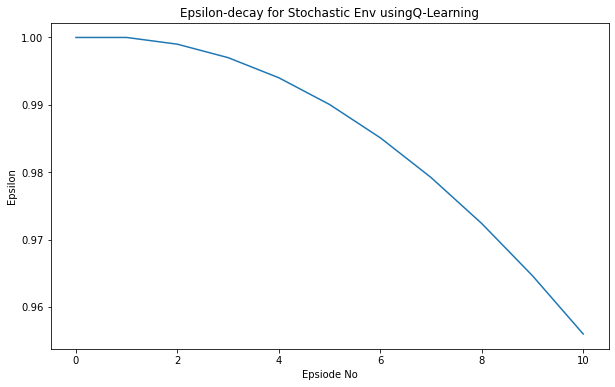

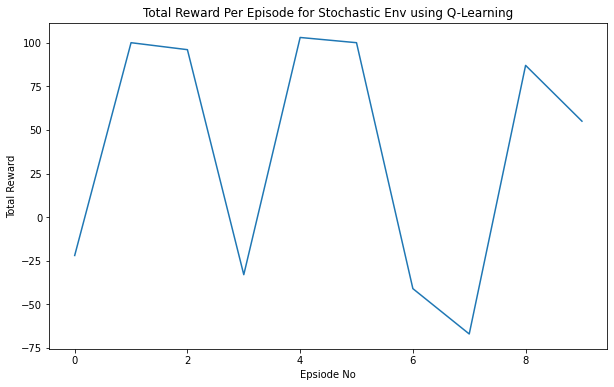

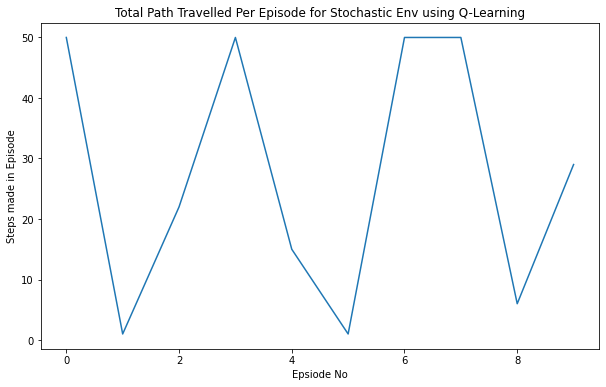

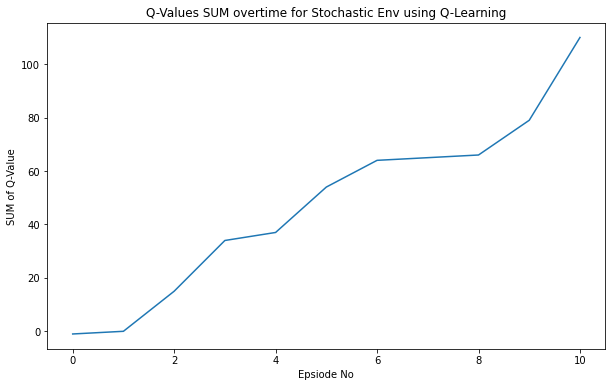

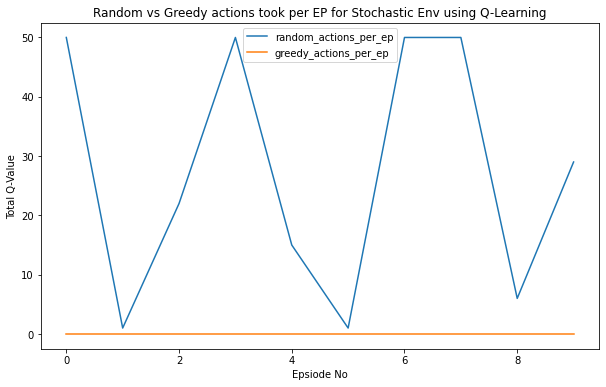

Starting-state,Total-Reward in an episode for all episodes 
0 [-41.0]
1 []
2 []
3 [-22.0, 103.0]
4 []
5 [96.0]
6 [-67.0]
7 [-33.0, 55.0]
8 []
9 []
10 []
11 [100.0, 100.0]
12 []
13 [87.0]
14 []
15 []


In [13]:
#run everything in default
main()

Q-Table
 [[ 0  0  0  0]
 [ 0 24  0  0]
 [ 0 52  1  0]
 [ 1  5  0 39]
 [ 0  0  0 11]
 [ 0  3 10 28]
 [ 1 37  3  3]
 [15 26 29 55]
 [ 1 36  4 -4]
 [ 3  5  6 70]
 [ 5 60  6 24]
 [30 54 50 83]
 [ 0 41  1  0]
 [-1 82 24 12]
 [39 94 18 37]
 [ 0  0  0  0]]


/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/1772298844.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


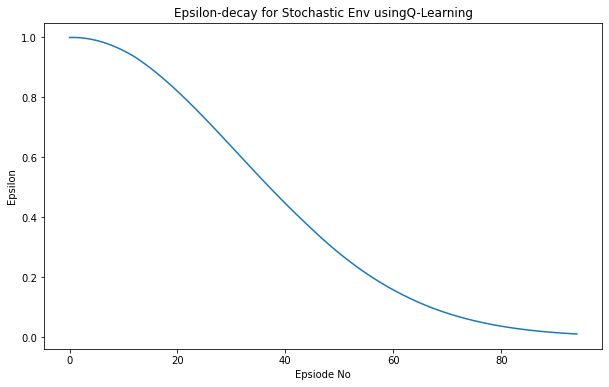

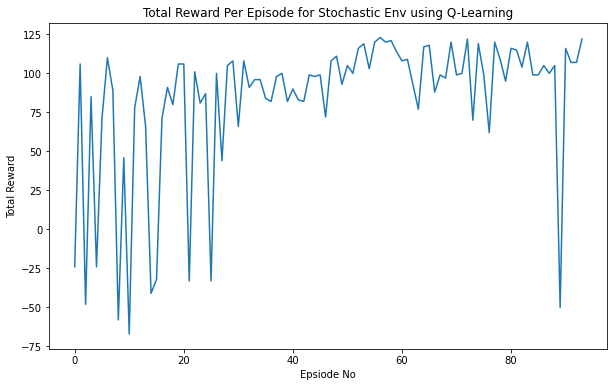

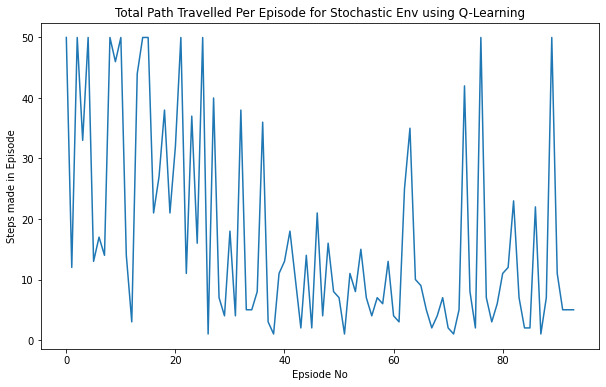

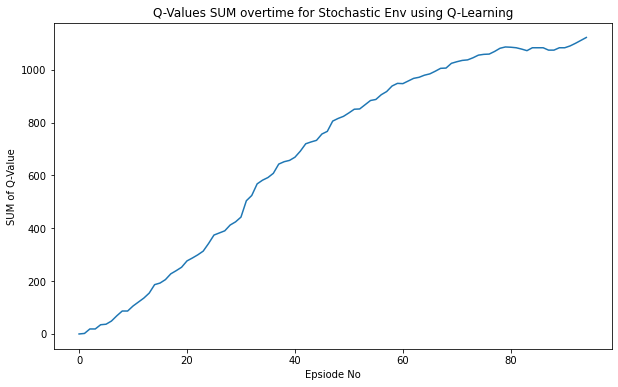

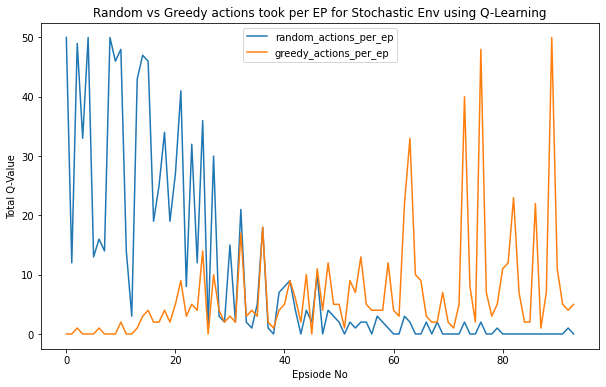

Starting-state,Total-Reward in an episode for all episodes 
0 [-67.0, 120.0, 77.0, 62.0, -50.0]
1 [-24.0, -24.0, 110.0, 106.0, 101.0, 84.0, 119.0, 93.0, 118.0, 120.0, 120.0, 116.0, 122.0]
2 [71.0, 80.0, 116.0, 123.0, 121.0, 122.0, 105.0]
3 [78.0, -32.0, 44.0, 96.0, 82.0, 120.0]
4 [82.0, 98.0, 88.0, 70.0, 105.0, 107.0]
5 [-48.0, 87.0, 120.0, 108.0, 107.0]
6 [83.0, 111.0, 93.0, 117.0, 104.0]
7 [85.0, 81.0, 96.0, 98.0, 99.0, 103.0, 114.0, 99.0]
8 [72.0, 108.0, 105.0]
9 [106.0, 105.0, 109.0]
10 [46.0, 66.0, 91.0, -33.0, -33.0, 91.0, 82.0, 99.0, 119.0, 95.0]
11 [106.0, 100.0, 100.0, 100.0, 116.0, 115.0]
12 [108.0, 66.0, 90.0, 109.0]
13 [89.0, -58.0, 99.0, 97.0, 99.0, 99.0]
14 [71.0, 98.0, -41.0, 108.0, 100.0, 99.0, 100.0]
15 []


In [14]:
episodes = 100
main(episodes=episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/1772298844.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 0  0  0 26]
 [ 5 50  0  0]
 [ 0 70  0  0]
 [22  8 23 59]
 [ 0 40  0  0]
 [ 0 49  0  0]
 [ 2 60  2 18]
 [23 37 39 71]
 [ 0 47  1  0]
 [ 1 57  0  0]
 [ 3 77 32 19]
 [33 60 51 89]
 [ 0 70  0  0]
 [-2 82 13 14]
 [28 94 18 35]
 [ 0  0  0  0]]


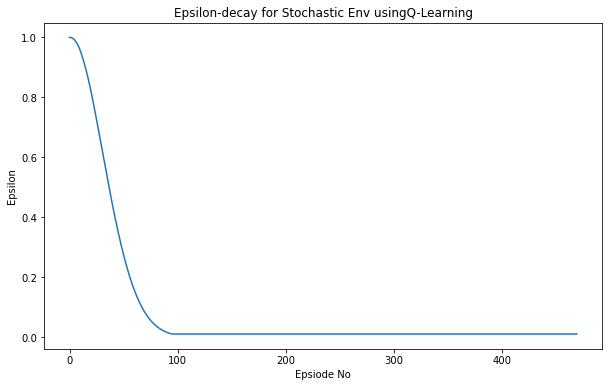

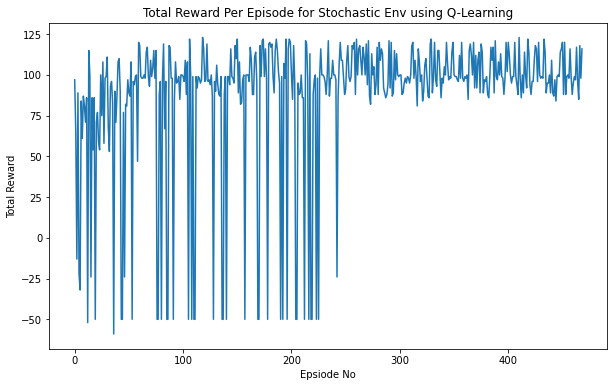

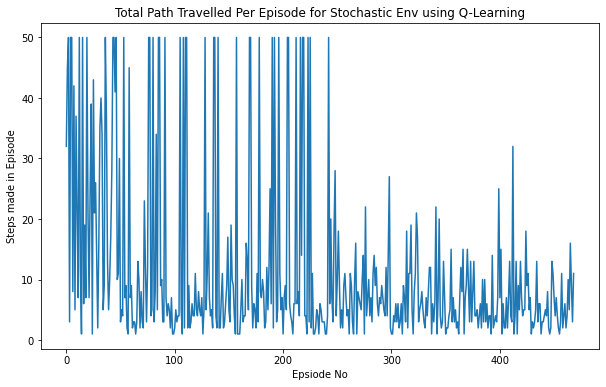

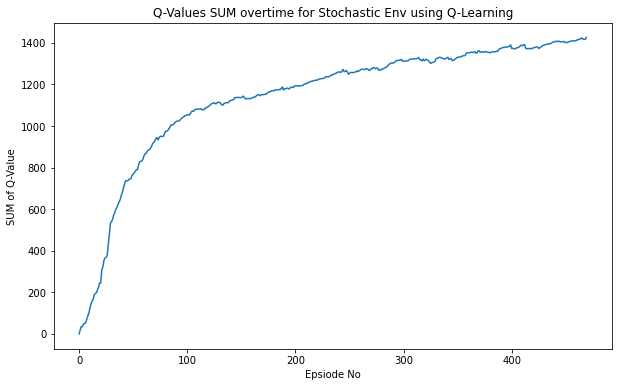

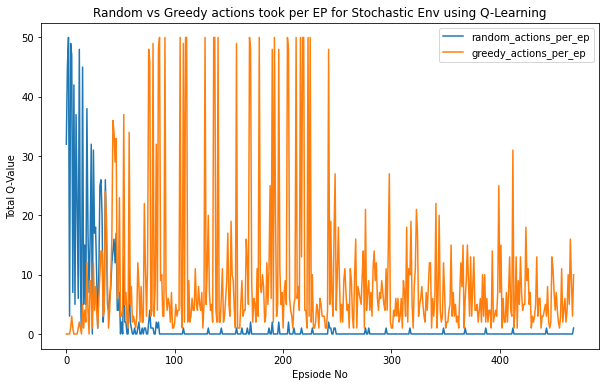

Starting-state,Total-Reward in an episode for all episodes 
0 [-50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 91.0, 109.0, 113.0, 92.0, 92.0, 95.0, 112.0, 92.0, 113.0, 94.0, 88.0, 114.0, 95.0, 95.0, 85.0]
1 [81.0, 54.0, 53.0, -59.0, -50.0, -50.0, 67.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -24.0, 113.0, 89.0, 113.0, 100.0, 116.0, 122.0, 120.0, 120.0, 120.0, 114.0, 118.0, 116.0, 114.0, 117.0]
2 [87.0, -50.0, 115.0, 119.0, 117.0, 122.0, 116.0, 108.0, -50.0, 114.0, 121.0, 122.0, 120.0, 117.0, 122.0, 118.0, 107.0, 120.0, 118.0, 116.0, 122.0, 116.0, 118.0, 117.0, 121.0, 118.0, 120.0, 120.0, 119.0, 121.0, 102.0, 122.0, 120.0, 118.0]
3 [115.0, 75.0, 111.0, 110.0, 98.0, 98.0, 117.0, 115.0, 119.0, 96.0, 97.0, 116.0, 118.0, 122.0, 98.0, 115.0, 102.0, 122.0, 121.0, 98.0, 120.0, 121.0, 116.0, 98.0, 110.0, 98.0, 120.0, 120.0, 123.0, 98.0, 116.0]
4 [93.0, 71.0, -24.0, -50.0, 114.0, 93.0, 96.0, 118

In [15]:
episodes = 500 
main(episodes=episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/1772298844.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 0  0  3 13]
 [ 7  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 5  1  6 28]
 [13  0  0  0]
 [ 1  1  0 21]
 [ 0  1 28  9]
 [ 5 42 10  0]
 [ 4 51 11 42]
 [20 16  3 69]
 [ 7  7 74 15]
 [ 8 82  0  0]
 [22 82 19 24]
 [46 94 47 37]
 [ 0  0  0  0]]


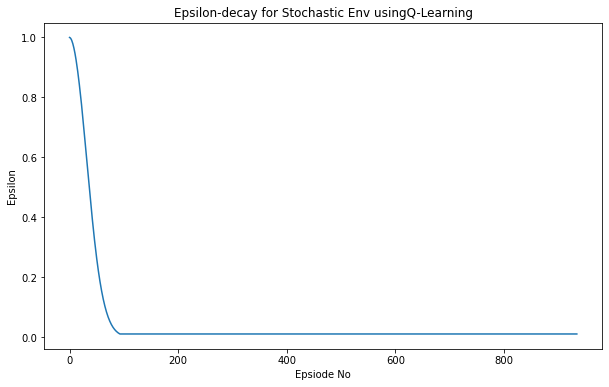

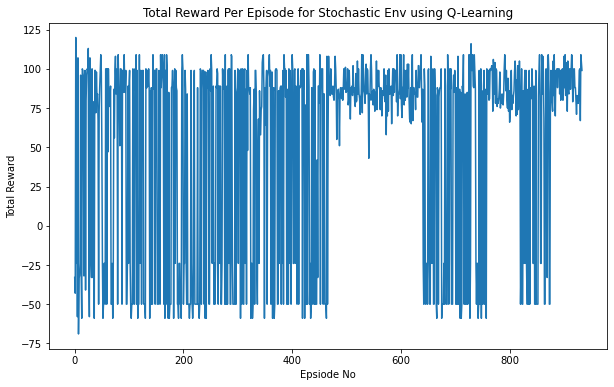

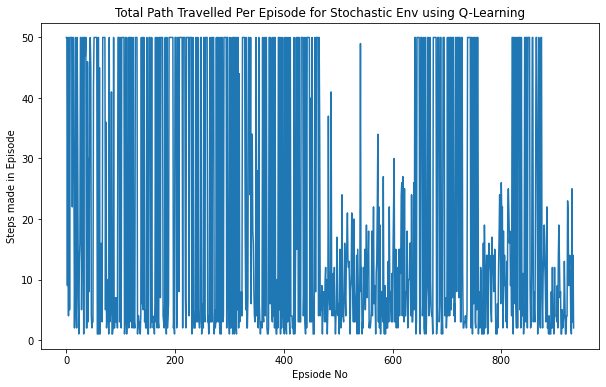

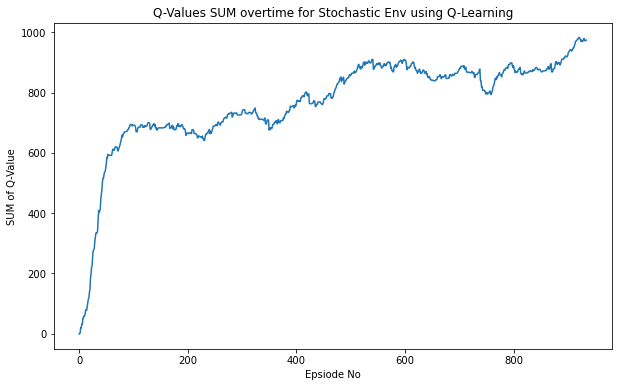

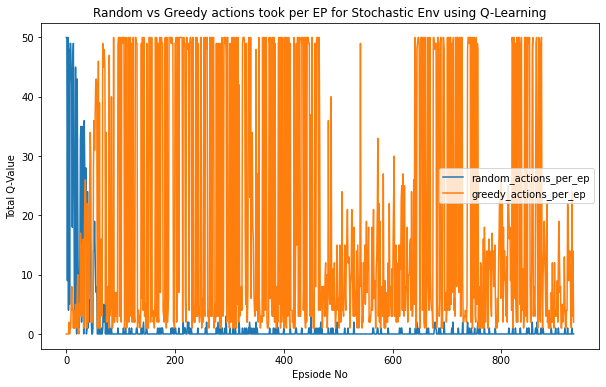

Starting-state,Total-Reward in an episode for all episodes 
0 [-58.0, -32.0, 56.0, -50.0, 84.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 84.0, 80.0, 81.0, 86.0, 85.0, 72.0, 43.0, 73.0, 85.0, 74.0, 81.0, 84.0, 77.0, 84.0, 82.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 84.0, 72.0, 78.0, 83.0, 69.0, -50.0, 81.0, 78.0, 80.0, 73.0, 84.0, 83.0]
1 [-59.0, 80.0, -22.0, 67.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 64.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 83.0, 80.0, 68.0, 83.0, 85.0, 79.0, 84.0, 81.0, 80.0, 79.0, 58.0, 83.0, 81.0, 68.0, 67.0, 82.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 80.0, 81.0, 75.0, -50.0, -50.0, -50.0, -50.0, 83.0]
2 [113.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, 44.0, 68.0, 58.0, 76.0,

In [16]:
episodes = 1000
main(episodes=episodes)

/var/folders/g6/s8f0t0ys2rx1j7n5nfjtcp680000gn/T/ipykernel_2314/1772298844.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state_rewards = np.empty(16, dtype=np.object) #(for rewards collected for each state during all episodes)


Q-Table
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  9 23]
 [ 3  0  0  0]
 [ 0 17  0  0]
 [ 1 30  0  2]
 [12  6 10 41]
 [ 0  0 17  9]
 [ 0 21 -3  0]
 [ 1 45  1  3]
 [23 26 21 76]
 [13 11 15 60]
 [ 2 26  0  0]
 [ 0 52  2  3]
 [11 94 38 54]
 [ 0  0  0  0]]


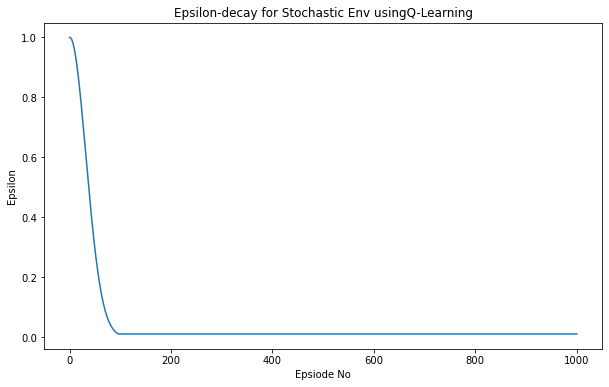

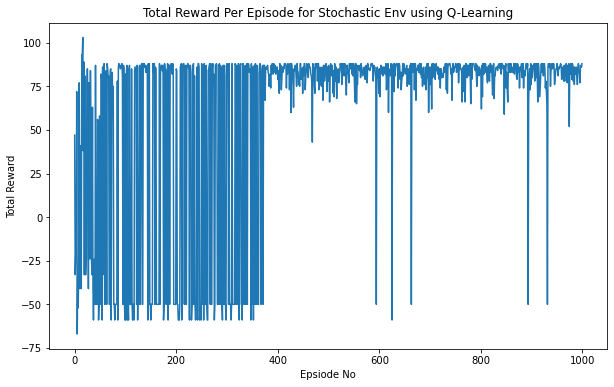

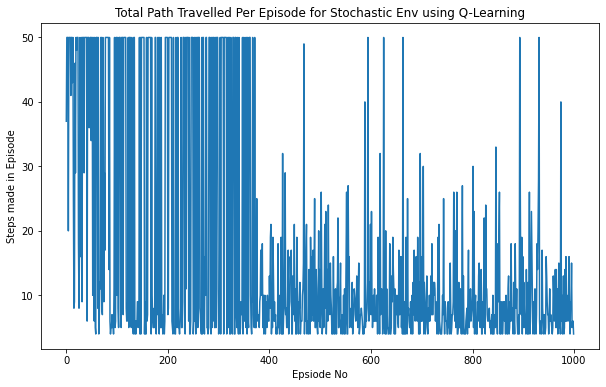

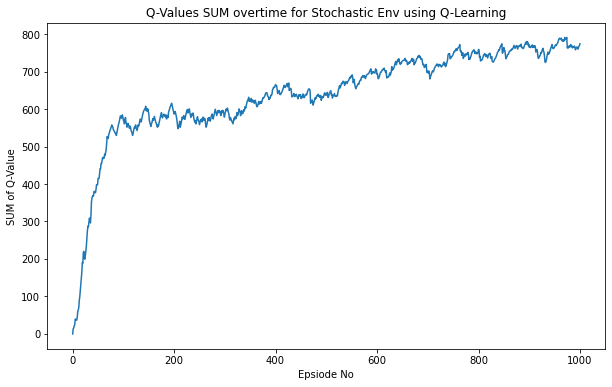

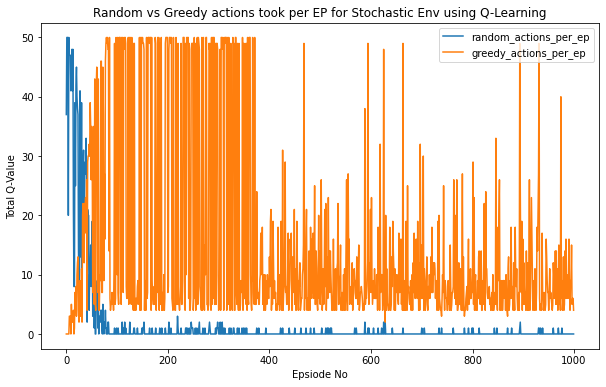

Starting-state,Total-Reward in an episode for all episodes 
0 []
1 []
2 []
3 []
4 []
5 [47.0, -33.0, -22.0, -22.0, 72.0, -67.0, -33.0, -52.0, -22.0, 77.0, -41.0, -22.0, 41.0, -41.0, 93.0, 93.0, 103.0, 38.0, 89.0, -33.0, 81.0, -33.0, -33.0, -24.0, 74.0, 85.0, 66.0, -41.0, 77.0, 72.0, -24.0, 84.0, 43.0, -24.0, -33.0, 63.0, -41.0, -59.0, -33.0, -24.0, -50.0, 87.0, -24.0, -50.0, -50.0, 56.0, 53.0, -59.0, -50.0, 58.0, -50.0, -50.0, 82.0, 79.0, -59.0, 86.0, -33.0, 87.0, 88.0, -50.0, -50.0, -24.0, 84.0, -50.0, 88.0, 85.0, 80.0, 81.0, -50.0, -50.0, 84.0, 85.0, -59.0, 54.0, 83.0, 63.0, 75.0, -50.0, -50.0, -59.0, -50.0, -50.0, -50.0, -50.0, 78.0, -59.0, 86.0, 88.0, 87.0, 87.0, 85.0, 87.0, 86.0, 88.0, 81.0, -50.0, 87.0, 86.0, -50.0, -59.0, 82.0, -59.0, 84.0, 87.0, -59.0, -50.0, -59.0, 85.0, 87.0, -50.0, -50.0, -50.0, 85.0, -50.0, -59.0, -50.0, -50.0, -59.0, 84.0, 86.0, 86.0, 83.0, -50.0, 87.0, -59.0, -24.0, -50.0, 86.0, 87.0, -50.0, 85.0, 87.0, 88.0, -50.0, -50.0, 88.0, 86.0, 88.0, 86.0, 87.0, 83

In [17]:
episodes = 1000 
specific_start_state = 5
main(episodes=episodes,random_start_state=0,specific_start_state=specific_start_state)

### some helping tester functions

In [ ]:
env = GridEnvironment()
env.state = 15
print(env.step(0))
print(env.step(1))
print(env.step(2))
print(env.step(3))

### single-step

In [ ]:
alpha = 0.9
epsilon = 0.9
gamma = 0.9

decay_rate = 0.01

env = GridEnvironment()
env.reset()

agent = RandomAgent(env,epsilon,decay_rate)

S = env.observation_space.sample()
env.state = S

A = agent.step(S)
NS , R, Done, Info = env.step(A)
agent.update_q_table(S,A,R,NS,alpha,gamma)

print(S,A,NS,R)
env.render()

print(agent.q_table)

### single-episode

In [ ]:
alpha = 0.15
epsilon = 1
gamma = 0.9

epsilon_decay_rate = 0.01

env = GridEnvironment()
env.reset()
agent = RandomAgent(env,epsilon,epsilon_decay_rate)

S = 6#env.observation_space.sample()
env.state = S

while S != env.terminal_state:    
    A = agent.step(S)
    NS , R, Done, Info = env.step(A)
    print(S,A,NS,R)
    
    agent.update_q_table(S,A,R,NS,alpha,gamma)
    S = NS
    env.state = S
agent.epsilon = agent.epsilon*((1-agent.epsilon_decay_rate)**agent.time_step) #epsilon-exponential-decay

env.render()
print(agent.q_table)

### multi-episode

In [ ]:
alpha = 0.15
epsilon = 1
gamma = 0.9
epsilon_decay_rate = 0.05


episodes = 10

epsilon_vals = np.array([epsilon])

env = GridEnvironment()
env.reset()
agent = RandomAgent(env,epsilon,epsilon_decay_rate)
agent.reset()

for ep in range(episodes):

    S = env.observation_space.sample()
    env.state = S

    while S != env.terminal_state:    
        A = agent.step(S)
        NS , R, Done, Info = env.step(A)
        #print(S,A,NS,R)

        agent.update_q_table(S,A,R,NS,alpha,gamma)
        S = NS

        env.state = S
    agent.epsilon = agent.epsilon*((1-agent.epsilon_decay_rate)**ep)
    #print(agent.epsilon,ep)

    epsilon_vals = np.append(epsilon_vals,agent.epsilon)

env.render()
print(agent.q_table)

In [ ]:
gammas = [0.5,0.75,0.9]
for gamma in gammas:
    print("GAMMA = ",gamma,"\n\n")
    main(100,gamma)
    print("\n\n\n")

In [ ]:
episodes_count = [100,200,500]
for episodes in episodes_count:
    print("EPISODES = ",episodes,"\n\n")
    main(episodes,gamma)
    print("\n\n\n")

In [ ]:
def render(n):
        
        #n = self.observation_space.n
        state = np.zeros((n,n))
        
        current_cell = 5
        current_x,current_y = int(current_cell/4),current_cell%4 
        
        terminal_cell = 15
        terminal_x,terminal_y = int(terminal_cell/4),terminal_cell%4 
        
        print(current_x,current_y)
        
        state[current_x,current_y] = 0.5
        state[terminal_x,terminal_y] = 1
        
        plt.imshow(state)

In [ ]:
render(4)

In [ ]:
def get_next_state(state,action):
        x = int(state / 4)
        y = int(state % 4 )

        if action == 0: #move left
            y -= 1
        elif action == 1: #move right
            y += 1
        elif action == 2: #move up
            x -= 1
        elif action == 3: #move down
            x += 1
        else:
            return -1
 
        x = np.clip(x,0,3)
        y = np.clip(y,0,3)
        
        next_state = 4*x + y
        return next_state
        

In [ ]:
import gym

In [ ]:
env_name = "CartPole-v1"
env = gym.make(env_name)

In [ ]:
print(env.observation_space)
print(env.action_space)

In [ ]:
env.reset()
for _ in range(200):
    action = env.action_space.sample()
    env.step(action)
    env.render()

In [ ]:
epsilon = 0.9
for _ in range(10):
    rand_num = np.random.random()
    if epsilon > rand_num: # explore
        print(rand_num,np.random.randint(3))
    else: # exploit
        print(rand_num,np.argmax([1,-2,3,10]))

In [ ]:
np.argmax([1,-2,3,10])